## Random forest model for BSC graduation rates based on Freshman fall semester info

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

In [24]:
df = pd.read_csv('../data/anonymized_bsc_dataPVZ.csv')

C:\Users\pvanzand\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,20,21,23,24,26,27,29,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [59]:
#only select the 4 cohorts of interest
df_4 = df.loc[(df['Cohort'] == '14/FA') | (df['Cohort'] == '15/FA') | (df['Cohort'] == '16/FA')
              | (df['Cohort'] == '17/FA')]
df_4 = df_4.dropna(subset=['Sttr Term'])
#df_4

In [26]:
#pull out just the avg gpa of the 1st semester
df_sorted = df_4.sort_values(by = 'Sttr Term', ascending = True)
df_dropped = df_sorted.drop_duplicates(subset=['alt_id'])

In [27]:
#turning gpa data frame into a dictionary to be able to map it to our original dataframe
gpa_map = df_dropped.set_index('alt_id')['Sttr Term Gpa'].to_dict()

#making a new column in original data frame by mapping gpa
df_4['ffall_gpa'] = df_4['alt_id'].map(gpa_map)

In [28]:
#make new df of just basic freshman info
df_simple = df_4.sort_values(by = 'Sttr Term', ascending = True)
df_simple = df_simple.drop_duplicates(subset=['alt_id'])

In [29]:
#drop all the extra columns that won't matter
df_simple = df_simple.drop(columns = ['Sttr Term', 'course_#', 'course_title', 'Sttr Stu Credits', 'Sttr Attempted Cred', 'faculty',
                                      'Sttr Stu Final Grades', 'Sttr Term Gpa', 'SP1 Enr', 'SP1 Class', 'SP1 Major', 'FA2 Enr', 'FA2 Class',
                                      'FA2 Major', 'FA3 Enr', 'FA3 Class', 'FA4 Enr', 'FA4 Class', 'FA4 Major', 'FA5 Enr', 'faculty', 
                                      'FA3 Major', 'FA5 Class', 'FA5 Major', 'alt_id','FA6 Enr', 'FA6 Class', 'FA6 Major', 'Grad Term', 
                                      'Grad Year', 'Grad Major'])

In [30]:
#set X & y, do TTS
y = df_simple['Graduated']
X = df_simple.drop(columns=['Graduated'], axis=1)

In [31]:
#recode the graduation column so that N = 0 & Y = 1
mapping = {'N': 0, 'Y': 1}
y = y.map(mapping)

#initial TTS
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.25, random_state=2021)
#generate validation set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.25, random_state=2021)

In [32]:
# need to OHE categorical & scale continuous
num_cols = list(X_train.select_dtypes('number').columns)
print (num_cols)
cat_cols = list(X_train.select_dtypes('object').columns)
print (cat_cols)


['Sttr Cmpl Cred', 'ffall_gpa']
['Sttr Student Load', 'Cohort']


In [33]:
#scale both train & test continuous variables

# Instantiate StandardScaler
scaler = StandardScaler()
# fit on Imputed training data
scaler.fit(X_train[num_cols])
# transform training, validation, & tr data
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_tr_scaled = pd.DataFrame(scaler.transform(X_tr[num_cols]), columns=num_cols)

In [34]:
#encode just categorical features
# fit on categorical data
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[cat_cols])
# transform training and validation data
X_train_encoded = ohe.transform(X_train[cat_cols])
X_val_encoded = ohe.transform(X_val[cat_cols])
X_tr_encoded = ohe.transform(X_tr[cat_cols])

In [35]:
#convert categorical back to dataframe
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=ohe.get_feature_names())
X_tr_encoded_df = pd.DataFrame(X_tr_encoded, columns=ohe.get_feature_names())

In [36]:
#concatenate the two back together again
X_train_df = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_val_df = pd.concat([X_val_scaled, X_val_encoded_df], axis=1)
X_tr_df = pd.concat([X_tr_scaled, X_tr_encoded_df], axis=1)

### Random forests classifier

In [64]:
#Instantiate the RF model

rf_model = RandomForestClassifier(n_estimators = 100) 

In [65]:
rf_model.fit(X_train_df, y_train)

RandomForestClassifier()

In [66]:
# Training accuracy score
rf_model.score(X_train_df, y_train)

0.8643031784841075

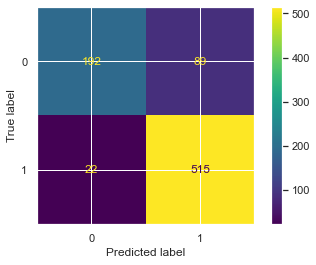

In [67]:
#plot confusion matrix
plot_confusion_matrix(rf_model, X_train_df, y_train)

In [61]:
rf_model.feature_importances_

array([0.16896621, 0.76690008, 0.00099261, 0.00119632, 0.01727539,
       0.01676075, 0.00975877, 0.01814987])

[0.16896621 0.76690008 0.00099261 0.00119632 0.01727539 0.01676075
 0.00975877 0.01814987]


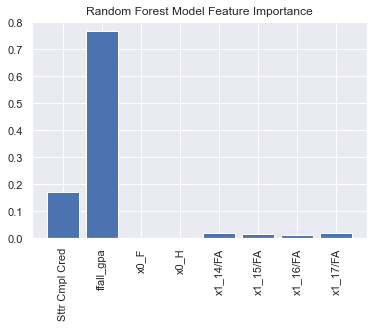

In [62]:
#visualize important features in this RF model
features = X_train_df.columns
print(rf_model.feature_importances_)
feature_df = pd.DataFrame({'Importance':rf_model.feature_importances_, 'Features': features })
sns.set()
plt.bar(feature_df['Features'], feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('Random Forest Model Feature Importance')
plt.show()

### gridsearch for RF model

In [72]:
# Create Param Grid 
param_grid = {'n_estimators': [90, 100, 110],
                'max_depth': [10, 15, 20],
                'min_samples_leaf': [6, 7, 8]}

In [73]:
# Create GridSearchCV
rf_gs = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy')

In [74]:
rf_gs.fit(X_train_df, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [6, 7, 8],
                         'n_estimators': [90, 100, 110]},
             scoring='accuracy')

In [75]:
best_model = rf_gs.best_estimator_

In [76]:
rf_gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 8, 'n_estimators': 100}

The best parameters from the grid search are (actually, they're all pretty comparable):
{'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 75}
{'max_depth': 15, 'min_samples_leaf': 7, 'n_estimators': 100}
{'max_depth': 10, 'min_samples_leaf': 8, 'n_estimators': 100}

### running RF w/ best params & eval on validation, then test sets

In [80]:
rf_best = RandomForestClassifier(max_depth= 15, min_samples_leaf= 7, n_estimators= 100) 

In [81]:
rf_best.fit(X_train_df, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=7)

In [82]:
# Training accuracy score
rf_best.score(X_train_df, y_train)

0.7591687041564792

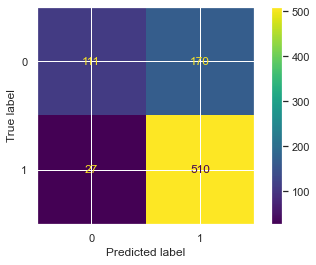

In [84]:
#plot confusion matrix
plot_confusion_matrix(rf_best, X_train_df, y_train)

In [83]:
# test accuracy score
rf_best.score(X_val_df, y_val)

0.6886446886446886

In [86]:
#making predictions
# y_pred = rf_best.predict(X_val)